## **STAT 430 Final Project**

> Author: Lucas Nelson

> Date: TBD

In this notebook, we want to design a playing style vector for each player given enough data of their on-ball actions. This analysis specfically focuses on the 2003-2004 season of Arsenal FC, an English club that competes in the Premier League. Data is provided by StatsBomb OpenAccess.

---
---

### 00. Imported Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

from statsbombpy import sb
from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer.cm import create_transparent_cmap
from mplsoccer.statsbomb import read_event, EVENT_SLUG

import seaborn as sns
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from warnings import filterwarnings
from statsbombpy.api_client import NoAuthWarning
filterwarnings('ignore', category=NoAuthWarning)
filterwarnings('ignore', category=FutureWarning)

In [2]:
# sb.competitions()

---
---
### 01. Filtering Play-by-Play Data per Match

In [3]:
invincibles_df = sb.matches(competition_id=2, season_id=44).sort_values('match_date').reset_index(drop=True)

In [4]:
# convert list column to two string columns
list_to_string = lambda x: ','.join([str(i) for i in x])

In [5]:
# yessirrrrrrr
def preprocessing_events_df(
    events_df,
    o_cols=['player', 'location', 'type', 'pass_end_location',
        'shot_outcome', 'dribble_outcome', 'pass_cross', 'shot_statsbomb_xg'],
    o_attrs=['Pass', 'Shot', 'Dribble', 'Cross'],
    time_cols=['match_id', 'minute', 'second']
    ):
    '''
    Return dataframe that contains offense-related metrics
    found in `offensive_cols` and `offensive_attrs`

    > events_df: play-by-play dataframe of team formations,
                 match start/finish, and on-ball actions
    '''

    # events from specific match with valid on-ball player data
    nonempty_df = events_df[(events_df['player_id'].notna()) & (events_df['location'].notna()) & (events_df['team'] == 'Arsenal')][o_cols + time_cols]

    # select specific offensive actions (types)
    nonempty_df = nonempty_df[nonempty_df['type'].isin(o_attrs)]

    # split x,y coordinates of location data
    nonempty_df = pd.merge(
        nonempty_df,
        nonempty_df['location'].apply(list_to_string).str.split(',', expand=True),
        left_index=True, right_index=True, how='outer'
        )
    nonempty_df.rename(columns={0:'location_x', 1:'location_y'}, inplace=True)

    # split x,y coordinates of passing event data
    nonempty_df = pd.merge(
        nonempty_df,
        nonempty_df[nonempty_df['type'] == 'Pass']['pass_end_location'].apply(list_to_string).str.split(',', expand=True),
        left_index=True, right_index=True, how='outer'
        )
    nonempty_df.rename(columns={0:'pass_end_x', 1:'pass_end_y'}, inplace=True)

    # update type column to include crosses
    nonempty_df['type'] = np.where(nonempty_df['pass_cross'] == 1, 'Cross', nonempty_df['type'])

    # return dataframe with desired events
    return nonempty_df.drop(columns=['location', 'pass_end_location'])

We'll store the results in a dataframe that contains all on-ball, offensive-oriented actions performed by Arsenal players in the 33 (of 38) matches provided in this database.

In [6]:
master_df = pd.concat([
    preprocessing_events_df(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

To create our player vectors, we need to first separate out the actions by `player` to distinguish who did what and by `type` to learn more about how often (and - later on - where on the pitch) a player will commit an action. This will be saved in a dictionary for simplified looping later on.

In [7]:
grouped_df = master_df.drop(columns='match_id').groupby(['player', 'type'])

In [8]:
player_dict = {player : dict() for player in master_df['player'].unique()}

for player_type, type_df in grouped_df:
    player_dict[player_type[0]][player_type[1]] = type_df

Here we ensure each player has a dataframe for every type, even if they haven't registered an event for said type. This is to avoid errors in matrix operations due to differing shapes.

In [9]:
for player in player_dict:
    for action in ['Pass', 'Shot', 'Dribble', 'Cross']:
        if action not in player_dict[player].keys():
            player_dict[player][action] = pd.DataFrame([player, action, np.nan, np.nan, np.nan, 0, 0, 0, 0, 0, 0, 0]).T
            player_dict[player][action].columns=['player', 'type', 'shot_outcome', 'dribble_outcome', 
                'pass_cross', 'shot_statsbomb_xg', 'minute', 'second',
                'location_x', 'location_y', 'pass_end_x', 'pass_end_y']

---
---

#### 02. Aggregate Data for Arsenal

With specific player data out of the way, we can move onto aggregate team data to learn more about the team as a whole.

In [10]:
# def gather_team_data(match_id, events_df):
#     return pd.DataFrame(
#         {match_id : {
#             'xG' : events_df['shot_statsbomb_xg'].astype('float64').sum(),
#             'shots' : events_df[events_df['type'] == 'Shot'].shape[0],
#             'passes' : events_df[events_df['type'] == 'Pass'].shape[0],
#             'dribbles' : events_df[events_df['type'] == 'Dribble'].shape[0],
#             'goals' : events_df[events_df['shot_outcome'] == 'Goal'].shape[0]
#         }}
#     ).T


# arsenal_summary_statistics = pd.concat([
#     gather_team_data(idx, sb.events(match_id=idx))
#     for idx in invincibles_df['match_id']
# ])

In [11]:
# arsenal_summary_statistics

---
---

#### 03. Minute Data

Let's gather minutes data per player to scale our player data.

In [12]:
def gather_time_information(events_df):
    return events_df[(events_df['player_id'].notna()) & (events_df['team'] == 'Arsenal')][['match_id', 'player', 'minute', 'second']]

In [13]:
time_df = pd.concat([
    gather_time_information(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

In [14]:
time_per_match = time_df.groupby(['player', 'match_id']).agg({'minute': ['min', 'max']})
total_minutes_df = pd.DataFrame(time_per_match['minute']['max'] - time_per_match['minute']['min']).reset_index().groupby(['player', 'match_id']).sum().rename(columns={0:'minutes'})
total_minutes_dict = total_minutes_df.to_dict()

---
---

#### 04. Heatmaps to Vectors

In [15]:
# keys are action types, values will be dataframes containing each player's compressed heatmap
nmf_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}

In [16]:
def player_action_heatmap(player, action, nrows=24, ncols=25):
    if player not in player_dict:
        print(f'Invalid player entry: {player} not found')
        return None
    if action not in player_dict[player]:
        print(f'Invalid action type for {player}: {action} not found')
        return None
    
    player_total_mins = np.sum([total_minutes_dict['minutes'][tup] for tup in total_minutes_dict['minutes'] if tup[0] == player])

    heatmap_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}
    # create empty dataframe of specified dimensions
    heatmap_matrix = np.zeros(shape=(nrows, ncols))

    # partition the field evenly (could be altered depending on weights
    # of different grid patterns on the field)
    row_divs = np.round(np.linspace(0, 80, nrows), 2)
    col_divs = np.round(np.linspace(0, 120, ncols), 2)

    # iterate over rows and assign count to specific cell grid
    for _, action in player_dict[player][action][['location_x', 'location_y']].iterrows():
        # assign to closest row grid cell and column grid cell
        grid_row = np.abs(row_divs - np.float64(action['location_y'])).argmin()
        grid_col = np.abs(col_divs - np.float64(action['location_x'])).argmin()
        # argmin index out of bounds if closest to upper bound (nrows, ncols)
        if grid_row == nrows: grid_row -= 1
        if grid_col == ncols: grid_col -= 1
        # update corresponding grid cell (of player-action combo) by one adj. 90-min frequency
        heatmap_matrix[grid_row, grid_col] += 90 / player_total_mins
    
    return gaussian_filter(heatmap_matrix, sigma=1.5)

In [17]:
def compressed_heatmap_matrix(player_action_dict, nrows=24, ncols=25):
    nmf_dict = {action:pd.DataFrame([0]*600, index=range(600), columns=['dummy']) for action in ['Pass', 'Dribble', 'Shot', 'Cross']}
    
    for player in player_action_dict:
        for action in player_action_dict[player]:
            nmf_dict[action][player] = player_action_heatmap(player, action, nrows, ncols).reshape(1, 600)[0]
    
    return {action: nmf_dict[action].drop(columns='dummy') for action in ['Pass', 'Dribble', 'Shot', 'Cross']}

In [18]:
(_, nmf_pass_matrix), (_, nmf_dribble_matrix), (_, nmf_shot_matrix), (_, nmf_cross_matrix) = compressed_heatmap_matrix(player_action_dict=player_dict).items()

---
---

#### 05. Principal Component Analysis

We can consider all players in our dataframe when modeling their playing style vectors, or we could simply select a few to represent the entire dataset. Dimensionality reduction is sick, innit. Anyway, to choose how many player clusters to choose for each action type, we should probably see how many are needed to capture a specific amount of variance.


In [19]:
from sklearn.decomposition import PCA

In [20]:
nmf_explained_variances = [
    PCA(n_components=nmf_action_mat.shape[1]).fit(nmf_action_mat).explained_variance_ratio_.cumsum()
    for nmf_action_mat in [nmf_pass_matrix, nmf_shot_matrix, nmf_dribble_matrix, nmf_cross_matrix]
    ]

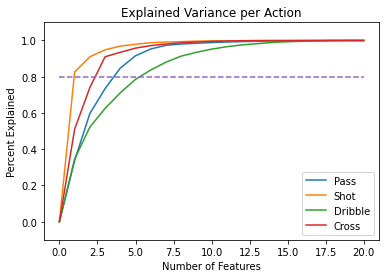

In [21]:
actions = ['Pass', 'Shot', 'Dribble', 'Cross']
for i, exp_var in enumerate(nmf_explained_variances):
    plt.plot(range(0, len(exp_var)+1), [0] + list(exp_var))

plt.plot(range(0,21), [0.8]*21, '--')
plt.title('Explained Variance per Action')
plt.ylabel('Percent Explained')
plt.xlabel('Number of Features')
plt.legend(['Pass', 'Shot', 'Dribble', 'Cross'])
plt.ylim([-0.1,1.1])
plt.show()

Of course, we could select the number of principal components based on the number of features needed to explain `x`% variance. Arbitrarily selecting 85%, we get:

In [22]:
for i, exp_var in enumerate(nmf_explained_variances):
    print(f'{actions[i]:<8}: {(exp_var >= .85).argmax()} component(s)')

Pass    : 4 component(s)
Shot    : 1 component(s)
Dribble : 6 component(s)
Cross   : 2 component(s)


Something seems off about that `Shot` selection. You're telling me we can explain a player's shooting tendencies using just one principal component? Nah that ain't right.

Regardless, seems like we have a couple options we can go with. Since this is a smaller dataset, we can expect the variance to be explained with few player clusters.

- Since shots happen so close to goal, of course the variance can be explained in so few (actually, just one) attributes.
- On the contrary, dribbles happen all over the pitch and serve many different purposes (whereas shots happen in one position of the pitch and serve one purpose); hence, requiring more components.
- Passes and crosses sit between the two for similar reasons.

Given that, let's choose our number of components per action type:

- Shot: 3 or 4 or 5 (we'll experiement)
- Cross: 2
- Pass: 4
- Dribble: 6


In [154]:
n_shot_components = 5       # final  : 5
n_cross_components = 4      # current: 2
n_pass_components = 5       # current: 4
n_dribble_components = 5    # current: 6

---
---
#### 06. Non-negative Matrix Factoriziation

Let's get into the thick of it. We'll start by analyzing each action type and see the results we get.

##### **Shot Data**

In [155]:
nmf_shot = NMF(n_components=n_shot_components, random_state=100)
nmf_shot_W = pd.DataFrame(nmf_shot.fit_transform(nmf_shot_matrix))
nmf_shot_H = pd.DataFrame(nmf_shot.components_, columns=nmf_shot_matrix.columns)
nmf_shot_clsmem = nmf_shot_W.apply(lambda x: x / sum(x), axis=1)

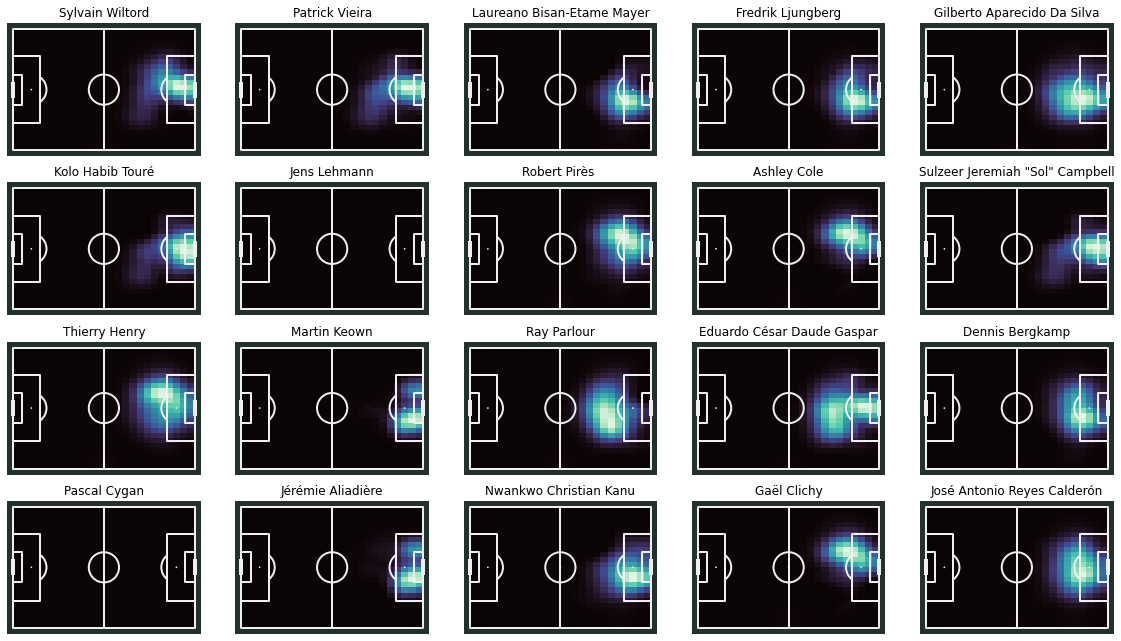

In [144]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_shot_H.columns):
    statistic = np.dot(nmf_shot_W, nmf_shot_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

In [156]:
np.corrcoef(
    np.dot(nmf_shot_W, nmf_shot_H['Thierry Henry'].to_numpy()),
    player_action_heatmap('Thierry Henry', 'Shot').reshape(1, 600)
)

array([[1.        , 0.99879748],
       [0.99879748, 1.        ]])

##### **Cross Data**

In [157]:
nmf_cross = NMF(n_components=n_cross_components, random_state=100)
nmf_cross_W = pd.DataFrame(nmf_cross.fit_transform(nmf_cross_matrix))
nmf_cross_H = pd.DataFrame(nmf_cross.components_, columns=nmf_cross_matrix.columns)
nmf_cross_clsmem = nmf_cross_W.apply(lambda x: x / sum(x), axis=1)

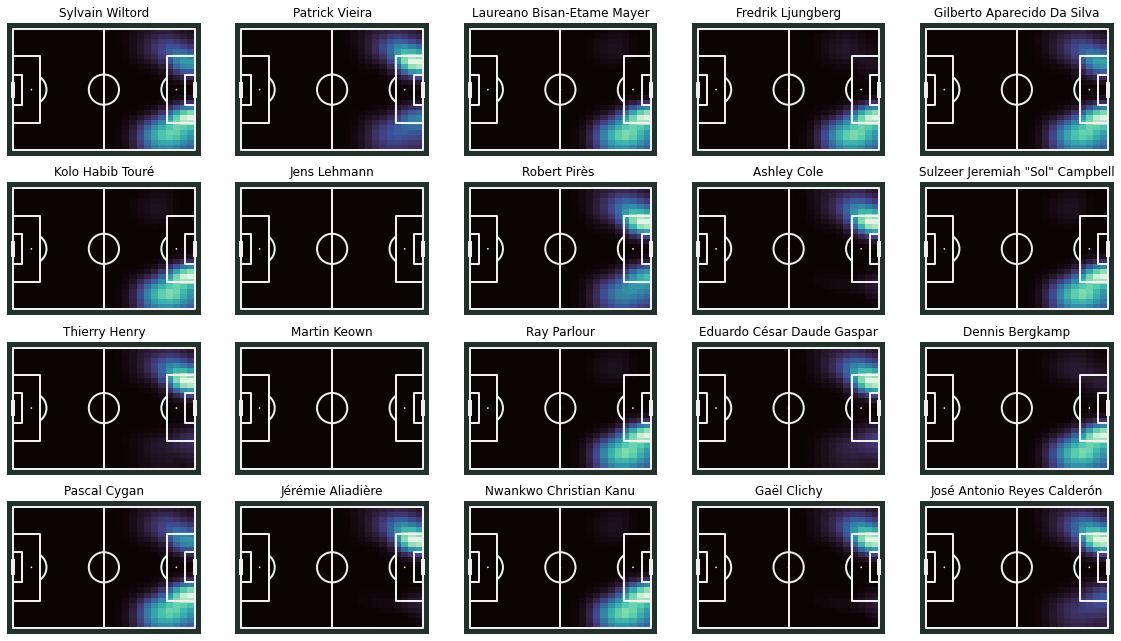

In [131]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_cross_H.columns):
    statistic = np.dot(nmf_cross_W, nmf_cross_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

In [158]:
np.corrcoef(
    np.diagonal(np.dot(nmf_cross_W, nmf_cross_H['Thierry Henry'].to_numpy()).reshape((24, 25))),
    np.diagonal(player_action_heatmap('Thierry Henry', 'Cross'))
)

array([[1.        , 0.98278766],
       [0.98278766, 1.        ]])

##### **Pass Data**

In [159]:
nmf_pass = NMF(n_components=n_pass_components, random_state=100)
nmf_pass_W = pd.DataFrame(nmf_pass.fit_transform(nmf_pass_matrix))
nmf_pass_H = pd.DataFrame(nmf_pass.components_, columns=nmf_pass_matrix.columns)
nmf_pass_clsmem = nmf_pass_W.apply(lambda x: x / sum(x), axis=1)

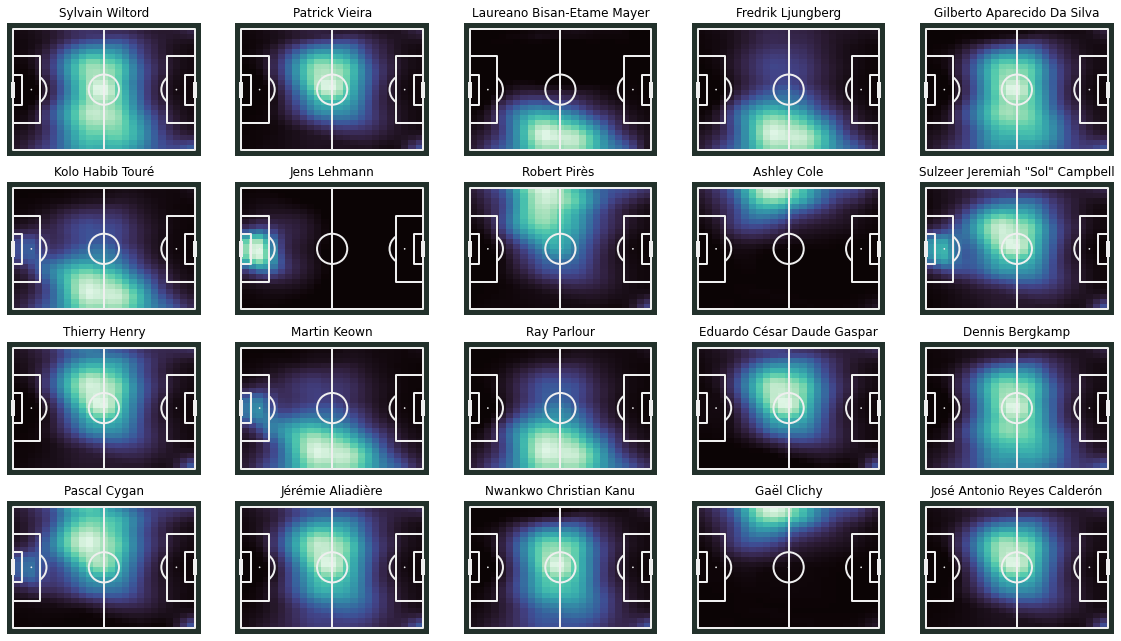

In [133]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_pass_H.columns):
    statistic = np.dot(nmf_pass_W, nmf_pass_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

In [160]:
np.corrcoef(
    np.diagonal(np.dot(nmf_pass_W, nmf_pass_H['Thierry Henry'].to_numpy()).reshape((24, 25))),
    np.diagonal(player_action_heatmap('Thierry Henry', 'Pass'))
)

array([[1.        , 0.98275711],
       [0.98275711, 1.        ]])

##### **Dribble Data**

In [161]:
nmf_dribble = NMF(n_components=n_dribble_components, random_state=100)
nmf_dribble_W = pd.DataFrame(nmf_dribble.fit_transform(nmf_dribble_matrix))
nmf_dribble_H = pd.DataFrame(nmf_dribble.components_, columns=nmf_dribble_matrix.columns)
nmf_dribble_clsmem = nmf_dribble_W.apply(lambda x: x / sum(x), axis=1)

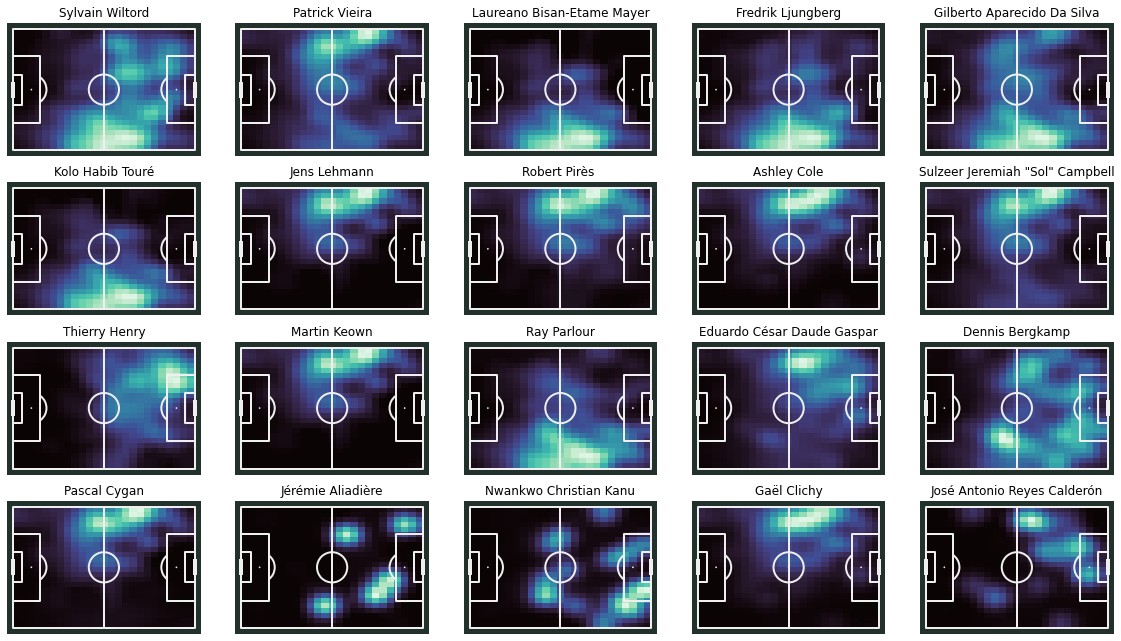

In [135]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_dribble_H.columns):
    statistic = np.dot(nmf_dribble_W, nmf_dribble_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

In [162]:
np.corrcoef(
    np.diagonal(np.dot(nmf_dribble_W, nmf_dribble_H['Thierry Henry'].to_numpy()).reshape((24, 25))),
    np.diagonal(player_action_heatmap('Thierry Henry', 'Dribble'))
)

array([[1.        , 0.94125588],
       [0.94125588, 1.        ]])

#### Preserved Information of NMF
Let's see how well we preserve Thierry Henry's shot heatmap using only four features.

---
---

#### 07. Evaluation

Let's see what each component looks like.

NMF Components for Shot


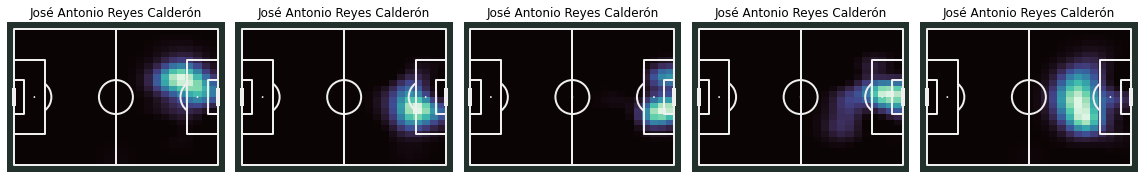

NMF Components for Dribble


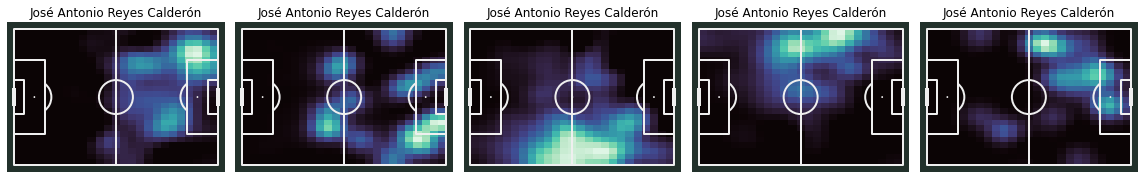

NMF Components for Pass


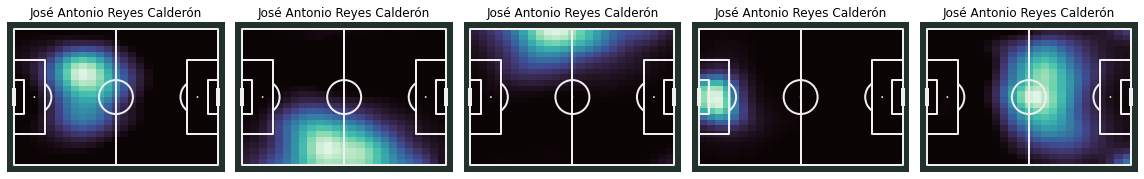

NMF Components for Cross


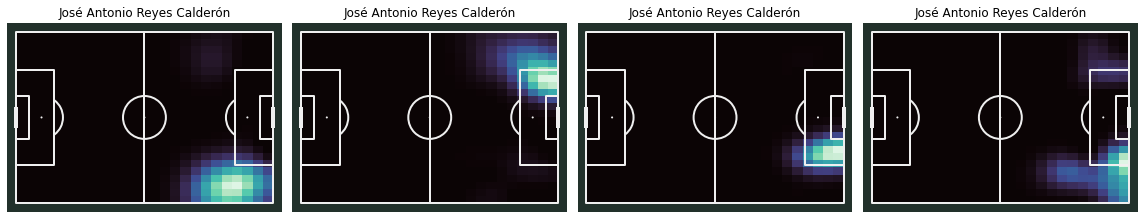

In [163]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')

for action, nmf_W in zip(
    ['Shot', 'Dribble', 'Pass', 'Cross'],
    [nmf_shot_W, nmf_dribble_W, nmf_pass_W, nmf_cross_W]
    ):

    print(f'NMF Components for {action}')
    fig, ax = pitch.draw(ncols=nmf_W.shape[1], figsize=(16,9))
    
    for i in range(nmf_W.shape[1]):
        
        statistic = np.array(nmf_W.iloc[:, i]).reshape((24, 25))

        # construct stats object from binned data, bin mesh, and bin centers
        y, x = statistic.shape
        x_grid = np.linspace(0, 120, x + 1)
        y_grid = np.linspace(0, 80, y + 1)
        cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
        cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
        stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

        pcm = pitch.heatmap(stats, ax=ax[i], cmap='mako')
        ax[i].set_title(player.title())
    
    plt.show()

Let's get some boxplots going in here for specific players. Henry, Bergkamp, Vieira, keeper, defenders. Possibly everyone.

In [183]:
nmf_player_dict = {
    player: nmf_shot_H[player].append(nmf_dribble_H[player].append(nmf_pass_H[player].append(nmf_cross_H[player]))).reset_index(drop=True)
    for player in player_dict.keys()
}

In [220]:
total_components = sum([n_shot_components, n_dribble_components, n_pass_components, n_cross_components])
nmf_component_dict = {}
for component in range(total_components):
    nmf_component_dict[f'C{component}'] = []
    for player in nmf_player_dict:
        nmf_component_dict[f'C{component}'].append(nmf_player_dict[player][component])

In [222]:
X = pd.DataFrame(nmf_component_dict)
mod_X = pd.melt(X, value_vars=X.columns, var_name='component')
mod_X['player'] = [player for player in player_dict.keys()] * total_components

<AxesSubplot:xlabel='component', ylabel='value'>

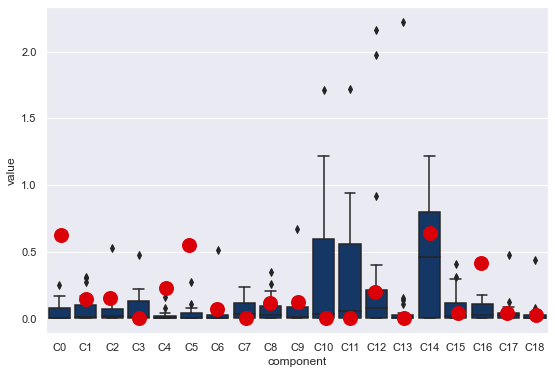

In [235]:
sns.set(rc={'figure.figsize':(9,6)})
sns.boxplot(x='component', y='value', color='#063672', data=mod_X)
sns.stripplot(x='component', y='value', color='#db0007', size=15, data=mod_X[mod_X['player'] == 'Thierry Henry'])

---
---

#### 0x. Finish

This bit here is gibberish

---
---

#### **Appendix** [Plotting Data]

For fun, we'll strictly gather Thierry Henry's shot, pass, dribble, and cross data to visualize each individual heat map below. This will tell us where on the pitch and how often Henry performs each action.

In [79]:
# maybe

---
---
#### **Appendix** [Trial Experiments]

---

##### NMF Results

---
#### Data Extraction

###### **COMPONENT WITH HEAVY FAVOR FOR LOCATION<40 IS CONSIDERING BACKPASSES TO KEEPER AND EXTENDED DRIBBLES**

In [80]:
offensive_df = master_df[master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross'])].copy()
offensive_df[['location_x', 'location_y']] = offensive_df[['location_x', 'location_y']].astype('float64')

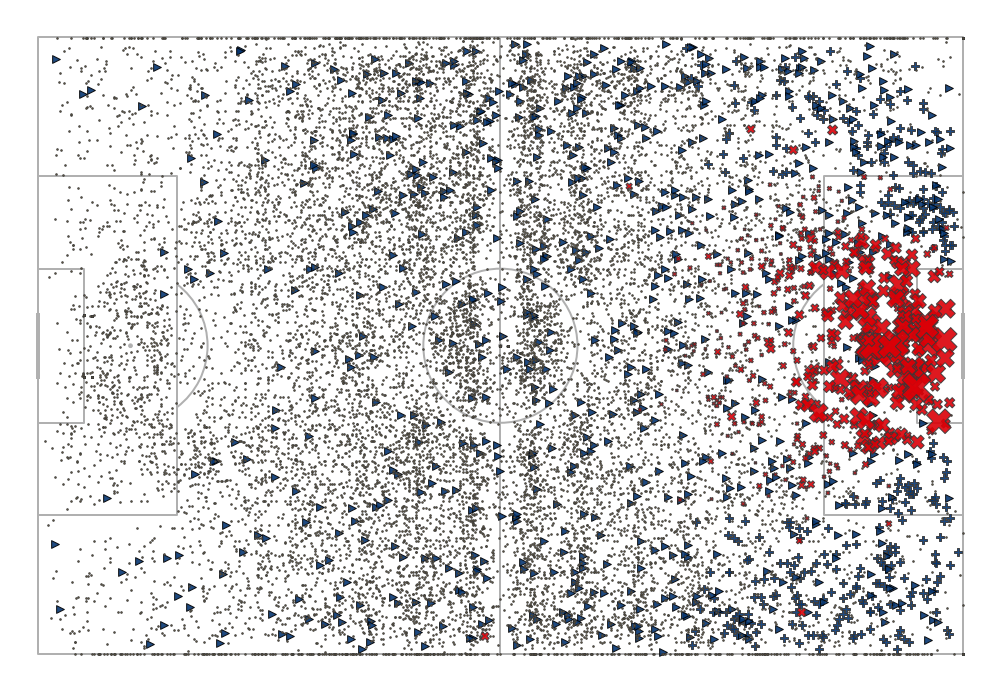

In [81]:
pitch = Pitch()
fig, ax = pitch.draw(figsize=(14, 12))


cross_df = offensive_df[offensive_df['type'] == 'Cross']
sc1 = pitch.scatter(cross_df['location_x'], cross_df['location_y'],
                   c='#063672',  # color for scatter in hex format
                   s=60, marker='P',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

dribble_df = offensive_df[offensive_df['type'] == 'Dribble']
sc1 = pitch.scatter(dribble_df['location_x'], dribble_df['location_y'],
                   c='#063672',  # color for scatter in hex format,
                   s=60, marker='>',
                   edgecolors='#000000', alpha=0.9,
                   ax=ax)

pass_df = offensive_df[offensive_df['type'] == 'Pass']
sc2 = pitch.scatter(pass_df['location_x'], pass_df['location_y'],
                   c='#9C824A',  # color for scatter in hex format
                   s=10, marker='.',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

shot_df = offensive_df[offensive_df['type'] == 'Shot']
sc3 = pitch.scatter(shot_df['location_x'], shot_df['location_y'],
                   c='#DB0007',  # color for scatter in hex format
                   s=shot_df['shot_statsbomb_xg'] * 900,
                   marker='X',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

plt.show()  # If you are using a Jupyter notebook you do not need this line

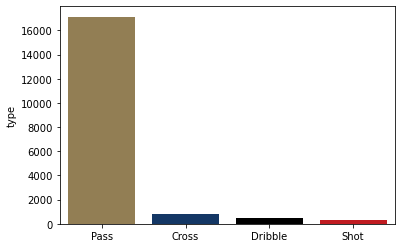

In [82]:
sns.barplot(x=offensive_df['type'].unique(), y=offensive_df['type'].value_counts(), palette=['#9C824A', '#063672', '#000000', '#DB0007'])
plt.show()

In [83]:
aggresive_df = master_df[(master_df['location_x'].astype('float64') >= 40) & (master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross']))].copy()
# aggresive_df = master_df[(master_df['location_x'].astype('float64') <= 24) & (master_df['location_y'].astype('float64') <= 25) & (master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross']))].copy()
aggresive_df[['location_x', 'location_y']] = aggresive_df[['location_x', 'location_y']].astype('float64')

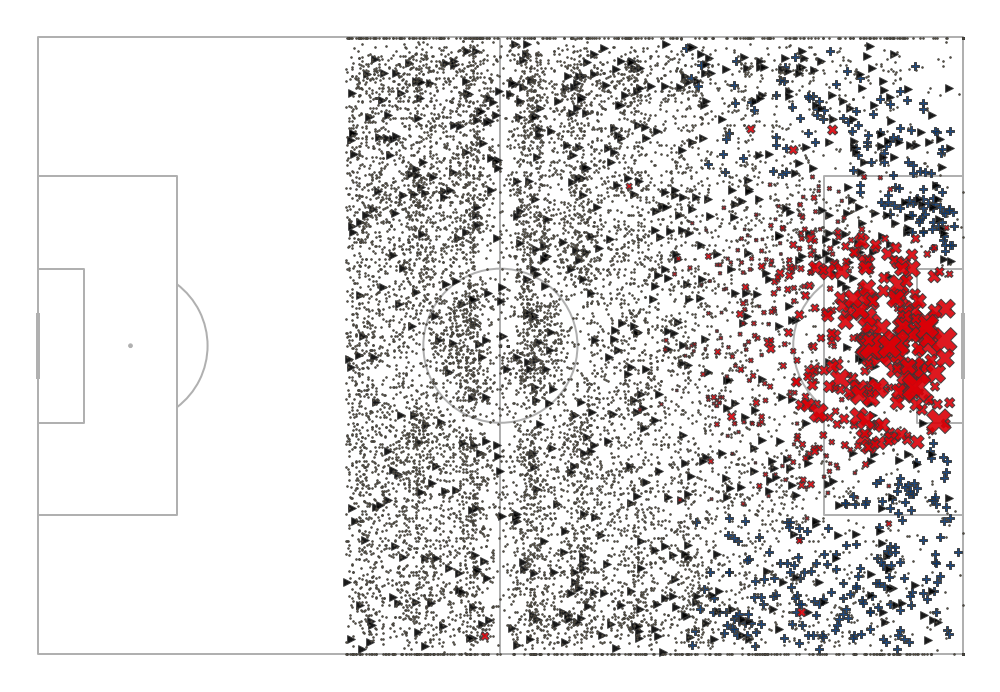

In [84]:
pitch = Pitch()
fig, ax = pitch.draw(figsize=(14, 12))


cross_df = aggresive_df[aggresive_df['type'] == 'Cross']
sc1 = pitch.scatter(cross_df['location_x'], cross_df['location_y'],
                   c='#063672',  # color for scatter in hex format
                   s=60, marker='P',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

dribble_df = aggresive_df[aggresive_df['type'] == 'Dribble']
sc1 = pitch.scatter(dribble_df['location_x'], dribble_df['location_y'],
                   c='#000000',  # color for scatter in hex format,
                   s=60, marker='>',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

pass_df = aggresive_df[aggresive_df['type'] == 'Pass']
sc2 = pitch.scatter(pass_df['location_x'], pass_df['location_y'],
                   c='#9C824A',  # color for scatter in hex format
                   s=10, marker='.',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

shot_df = aggresive_df[aggresive_df['type'] == 'Shot']
sc3 = pitch.scatter(shot_df['location_x'], shot_df['location_y'],
                   c='#DB0007',  # color for scatter in hex format
                   s=shot_df['shot_statsbomb_xg'] * 900,
                   marker='X',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

plt.show()  # If you are using a Jupyter notebook you do not need this line

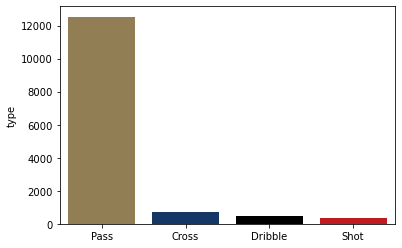

In [85]:
sns.barplot(x=aggresive_df['type'].unique(), y=aggresive_df['type'].value_counts(), palette=['#9C824A', '#063672', '#000000', '#DB0007'])
plt.show()

---

#### Plots

###### **> Arsenal Shot Distribution**

In [86]:
vertical_pitch = VerticalPitch(half=True, pad_top=0.05, pad_right=0.05, pad_bottom=0.05,
                               pad_left=0.05, line_zorder=2)
fm = FontManager()
fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))

In [87]:
arsenal_shot_df = master_df[master_df['type'] == 'Shot'].copy()
arsenal_shot_df[['location_x', 'location_y']] = arsenal_shot_df[['location_x', 'location_y']].astype('float64')

###### **> Marked Shot Distribution**

In [88]:
fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency

In [89]:
# filter goals / non-shot goals
arsenal_non_goal_df = master_df[(master_df['type'] == 'Shot') & (master_df['shot_outcome'] != 'Goal')].copy()
arsenal_non_goal_df[['location_x', 'location_y']] = arsenal_non_goal_df[['location_x', 'location_y']].astype('float64')
arsenal_goal_df = master_df[(master_df['type'] == 'Shot') & (master_df['shot_outcome'] == 'Goal')].copy()
arsenal_goal_df[['location_x', 'location_y']] = arsenal_goal_df[['location_x', 'location_y']].astype('float64')

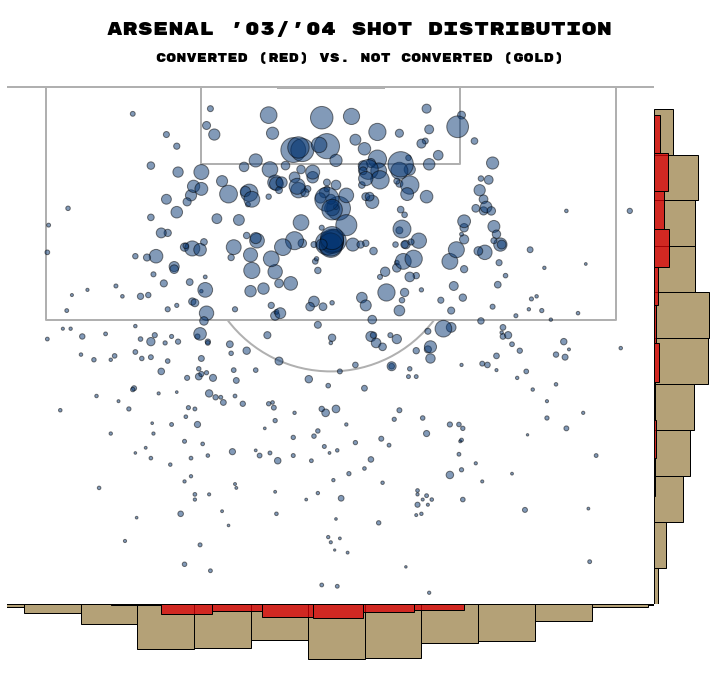

In [92]:
vertical_pitch = VerticalPitch(half=True,
                               # here we remove some of the pitch on the left/ right/ bottom
                               pad_top=0.05, pad_right=-15, pad_bottom=-20, pad_left=-15,
                               goal_type='line')

fig, axs = vertical_pitch.jointgrid(figheight=10, left=None, bottom=None,  # center aligned
                                    grid_width=0.95, marginal=0.1,
                                    # setting up the heights/space so it takes up 95% of the figure
                                    grid_height=0.80,
                                    title_height=0.1, endnote_height=0.03,
                                    title_space=0.01, endnote_space=0.01,
                                    axis=False,  # turn off title/ endnote/ marginal axes
                                    # here we filter out the left and top marginal axes
                                    ax_top=False, ax_bottom=True,
                                    ax_left=False, ax_right=True)

# typical shot map where the scatter points vary by the expected goals value
# using alpha for transparency as there are a lot of shots stacked around the six-yard box
sc_team2 = vertical_pitch.scatter(arsenal_shot_df['location_x'], arsenal_shot_df['location_y'], s=arsenal_shot_df['shot_statsbomb_xg'] * 700,
                                  alpha=0.5, ec='black', color='#063672', ax=axs['pitch'])
# kdeplots on the marginals
# remember to flip the coordinates y=x, x=y for the marginals when using vertical orientation
team2_hist_x = sns.histplot(y=arsenal_non_goal_df['location_x'], ax=axs['right'], color='#9C824A')
team2_hist_y = sns.histplot(x=arsenal_non_goal_df['location_y'], ax=axs['bottom'], color='#9C824A')
team2_hist_x = sns.histplot(y=arsenal_goal_df['location_x'], ax=axs['right'], color='#DB0007')
team2_hist_y = sns.histplot(x=arsenal_goal_df['location_y'], ax=axs['bottom'], color='#DB0007')

# titles and endnote
axs['title'].text(0.5, 0.7, "Arsenal '03/'04 Shot Distribution", color='black',
                  fontproperties=fm_rubik.prop, fontsize=18, ha='center', va='center')
axs['title'].text(0.5, 0.3, "Converted (red) vs. Not Converted (gold)", color='black',
                  fontproperties=fm_rubik.prop, fontsize=12, ha='center', va='center')

plt.show()  # If you are using a Jupyter notebook you do not need this line